# Hyperparameter Tuning using HyperDrive

TODO: Import Dependencies. In the cell below, import all the dependencies that you will need to complete the project.

In [56]:
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.stats import norm
#!pip install pandas_datareader
from pandas_datareader import data
from azureml.core import Workspace, Dataset, Experiment, Run
from azureml.train.automl import AutoMLConfig
from azureml.widgets import RunDetails
from azureml.core.compute import AmlCompute, ComputeTarget
from azureml.core.compute_target import ComputeTargetException
from azureml.train.automl.run import AutoMLRun
from azureml.core.model import Model, InferenceConfig
from azureml.core.environment import Environment
from azureml.core.webservice import AciWebservice
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
# Webservice
import urllib.request
import json
import os
import ssl

# Data Manipulation
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, Callback
import tensorflow.keras as tf

# AzureML
from azureml.core import Workspace, Dataset, Experiment, Run
from azureml.train.hyperdrive import HyperDriveRun
from azureml.widgets import RunDetails
from azureml.core.compute import AmlCompute
from azureml.core.compute import ComputeTarget
from azureml.core.compute_target import ComputeTargetException
from azureml.train.hyperdrive import RandomParameterSampling, BanditPolicy, HyperDriveConfig, PrimaryMetricGoal
from azureml.train.hyperdrive import choice
from azureml.train.dnn import TensorFlow

## Dataset

TODO: Get data. In the cell below, write code to access the data you will be using in this project. Remember that the dataset needs to be external.

In [57]:
ws = Workspace.from_config()
experiment_name = 'MSFT-stock'
experiment=Experiment(ws, experiment_name)

In [73]:
dataset_prepared = Dataset.get_by_name(ws, name='MSFT-stock cleaned')

df = dataset_prepared.to_pandas_dataframe()
df = df.set_index('Date', inplace=False) 
df.head()

,Adj Close
Date,
2019-01-02,98.148849
2019-01-03,94.538162
2019-01-04,98.935059
2019-01-07,99.061226
2019-01-08,99.779510


## Hyperdrive Configuration

TODO: Explain the model you are using and the reason for chosing the different hyperparameters, termination policy and config settings.

In [59]:
amlcompute_cluster_name = "AMLForecasting"

# Verify that cluster does not exist already
try:
    compute_target = ComputeTarget(workspace=ws, name=amlcompute_cluster_name)
    print('Found existing cluster, use it.')
except ComputeTargetException:
    print('No cluster found')
    compute_config = AmlCompute.provisioning_configuration(vm_size='STANDARD_DS3_V2',                                                           
                                                           max_nodes=4,
                                                          min_nodes = 1, idle_seconds_before_scaledown = 600)
    compute_target = ComputeTarget.create(ws, amlcompute_cluster_name, compute_config)

compute_target.wait_for_completion(show_output=True)

Found existing cluster, use it.
Succeeded
AmlCompute wait for completion finished

Minimum number of nodes requested have been provisioned


In [84]:
# Prepare data for NN training

# Preprocessing

def dnn_2d(df, look_back):
    X,Y =[], []
    for i in range(len(df)-look_back):
        d=i+look_back
        X.append(df[i:d,0])
        Y.append(df[d,0])
    return np.array(X),np.array(Y)

train_size =160

train, test = df.values[0:train_size,:], df.values[train_size:,:]

look_back = 12

def model_dnn(look_back):
    model = Sequential()
    model.add(Dense(units=32, input_dim=look_back, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam', metrics = ['mae',tf.metrics.RootMeanSquaredError()])

    return model

# Training DNN

model = model_dnn(look_back)

X_train,y_train = dnn_2d(train,look_back)

X_test,y_test = dnn_2d(test,look_back)

history = model.fit([X_train], [y_train], epochs = 100, batch_size=32, verbose=0,
                    validation_data=([X_test],[y_test]),
#                     callbacks=[EarlyStopping(monitor='val_loss',patience=10)],
                    shuffle=False)

print('Done')

Done


Train Root Mean Squared Error(RMSE): 1.40; Train Mean Absolute Error(MAE) : 2.52 
Val Root Mean Squared Error(RMSE): 1.31; Test Mean Absolute Error(MAE) : 2.14 


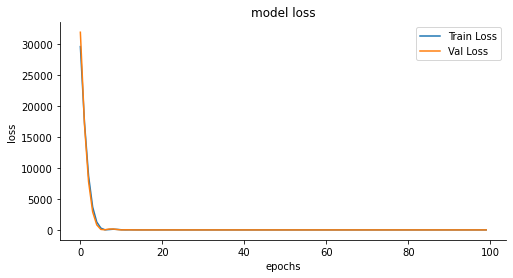

In [85]:
#TODO: Submit your experiment
def model_loss(history):
    plt.figure(figsize=(8,4))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epochs')
    plt.legend(loc='upper right')
    sns.despine(top=True)
    plt.show()
    
train_score = model.evaluate(X_train, y_train, verbose=0)
print('Train Root Mean Squared Error(RMSE): %.2f; Train Mean Absolute Error(MAE) : %.2f ' 
% (np.sqrt(train_score[1]), train_score[2]))
test_score = model.evaluate(X_test, y_test, verbose=0)
print('Val Root Mean Squared Error(RMSE): %.2f; Test Mean Absolute Error(MAE) : %.2f ' 
% (np.sqrt(test_score[1]), test_score[2]))
model_loss(history)

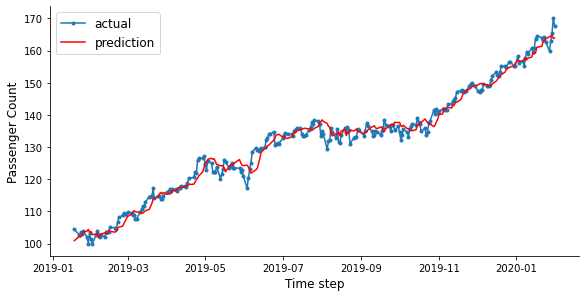

In [86]:
def prediction_plot(y_test, test_predict):
    len_prediction=df.index[look_back:]
    plt.figure(figsize=(8,4))
    plt.plot(len_prediction, y_test[:], marker='.', label="actual")    
    plt.plot(len_prediction, test_predict[:], 'r', label="prediction")
    plt.tight_layout()
    sns.despine(top=True)
    plt.ylabel('Passenger Count', size=12)
    plt.xlabel('Time step', size=12)
    plt.legend(fontsize=12)    
    plt.show()

Xa,ya = dnn_2d(df.values,look_back)

test_predict = model.predict(Xa)

prediction_plot(ya, test_predict)

## Run Details

OPTIONAL: Write about the different models trained and their performance. Why do you think some models did better than others?

TODO: In the cell below, use the `RunDetails` widget to show the different experiments.

In [87]:
def lstm_3d(df, look_back):
    X, Y =[], []
    for i in range(len(df)-look_back):
        d=i+look_back
        X.append(df[i:d,])
        Y.append(df[d,])
    return np.array(X), np.array(Y)


#create numpy.ndarray
df_arr= df.values
 
df_arr = np.reshape(df_arr, (-1, 1)) #LTSM requires more input features compared to RNN or DNN
scaler = MinMaxScaler(feature_range=(0, 1))#LTSM is senstive to the scale of features
df_arr = scaler.fit_transform(df_arr)

train_size =  160
test_size = len(df_arr)-train_size
train, test = df_arr[0:train_size,:], df_arr[train_size:len(df_arr),:]
look_back = 12
trainX, trainY = lstm_3d(train, look_back)
testX, testY = lstm_3d(test, look_back)
# reshape input to be [samples, time steps, features]
print(trainY.shape)
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

print(trainX.shape)

def model_lstm(look_back):
    model=Sequential()
#     model.add(LSTM(100, input_shape=(1, look_back), activation='relu'))
#     model.add(Dense(1))
    
    model.add(LSTM(64, activation='relu', input_shape=(1,look_back)))
    #lstm.add(LSTM(32, activation='relu', input_shape=(32,1)))
    model.add(Dense(10))
    model.add(Dropout(0.3))
    #lstm.add(Dense(10))
    #lstm.add(Dropout(0.3))
    model.add(Dense(1))
    
    model.compile(loss='mean_squared_error',  optimizer='adam',metrics = ['mse', 'mae'])

    
    return model


model=model_lstm(look_back)
history = model.fit(trainX, trainY, epochs=100, batch_size=30, validation_data=(testX, testY),
#                     callbacks=[EarlyStopping(monitor='val_loss', patience=10)],
                    verbose=0, shuffle=False)

train_predict = model.predict(trainX)
test_predict = model.predict(testX)

# invert predictions

train_predict = scaler.inverse_transform(train_predict)
trainY = scaler.inverse_transform(trainY)
test_predict = scaler.inverse_transform(test_predict)
testY = scaler.inverse_transform(testY)

print('Done')

(148, 1)
(148, 1, 12)
Done


Train Root Mean Squared Error(RMSE): 2.53; Train Mean Absolute Error(MAE) : 1.95 
Test Root Mean Squared Error(RMSE): 2.05; Test Mean Absolute Error(MAE) : 1.70 


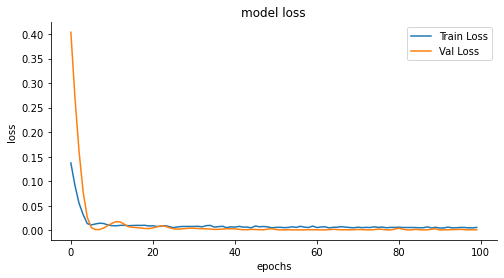

In [88]:
print('Train Root Mean Squared Error(RMSE): %.2f; Train Mean Absolute Error(MAE) : %.2f '% (np.sqrt(mean_squared_error(trainY[:,0], train_predict[:,0])),(mean_absolute_error(trainY[:,0], train_predict[:,0]))))
print('Test Root Mean Squared Error(RMSE): %.2f; Test Mean Absolute Error(MAE) : %.2f '% (np.sqrt(mean_squared_error(testY[:,0], test_predict[:,0])),(mean_absolute_error(testY[:,0], test_predict[:,0]))))


model_loss(history)

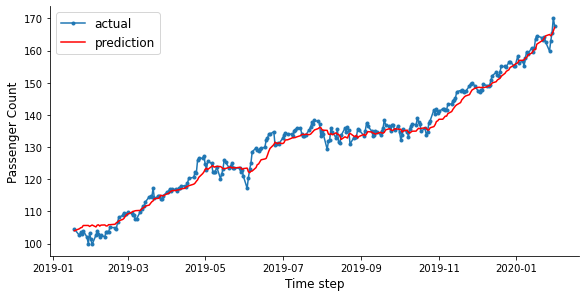

In [89]:
# Plot the prediction against the actual data
Xa,ya = lstm_3d(df_arr,look_back)
Xa = np.reshape(Xa, (Xa.shape[0], 1, Xa.shape[1]))

test_predict = model.predict(Xa)
ya = scaler.inverse_transform(ya)

test_predict = scaler.inverse_transform(test_predict)


prediction_plot(ya, test_predict)

In [90]:
# Create an early termination policy. This is not required if using Bayesian sampling.
early_termination_policy = BanditPolicy(slack_factor=0.1, evaluation_interval=1, delay_evaluation=5)

# Create the different params that will be using during training

script_params = {
    '--dataset':'MSFT-stock cleaned',   
}

param_sampling = RandomParameterSampling(
    {
        '--n_epochs': choice(100,200,500),
        '--model_type': choice('DNN','LSTM'),
        '--n_layers': choice(0,1,2),
        '--n_neurons': choice(16,64,128),
        '--look_back': choice(6,12,15),
        '--dropout': choice(0.0,0.2,0.3),
        '--batch_size': choice(16,64,128)
    }

)



# Create your estimator and hyperdrive config
estimator = TensorFlow(source_directory='.',
                 script_params=script_params,
                 compute_target=compute_target, 
                 entry_script='train.py',
                 pip_packages= [                            
                            "numpy",
                            "pandas",
                            "scikit-learn",
                            "matplotlib",
                            "seaborn",
                            "scikit-learn"
                 ])

hyperdrive_run_config = HyperDriveConfig(estimator=estimator,
                                         hyperparameter_sampling=param_sampling,
                                         policy=early_termination_policy,
                                         primary_metric_name='MAE_train',
                                         primary_metric_goal=PrimaryMetricGoal.MINIMIZE,
                                         max_total_runs=40,
                                         max_concurrent_runs=4,
                                         max_duration_minutes= 180)

In [91]:

# Submit the experiment
TRAIN = True

if TRAIN:
    hyperdrive_run = experiment.submit(hyperdrive_run_config)
    hyperdrive_run.wait_for_completion(show_output=True)

RunId: HD_bff31df8-400e-4a77-af84-e7d5f24ae165
Web View: https://ml.azure.com/runs/HD_bff31df8-400e-4a77-af84-e7d5f24ae165?wsid=/subscriptions/d4ad7261-832d-46b2-b093-22156001df5b/resourcegroups/aml-quickstarts-147313/workspaces/quick-starts-ws-147313&tid=660b3398-b80e-49d2-bc5b-ac1dc93b5254

Streaming azureml-logs/hyperdrive.txt

"<START>[2021-06-16T23:13:47.675288][API][INFO]Experiment created<END>\n""<START>[2021-06-16T23:13:48.100841][GENERATOR][INFO]Trying to sample '4' jobs from the hyperparameter space<END>\n""<START>[2021-06-16T23:13:48.393513][GENERATOR][INFO]Successfully sampled '4' jobs, they will soon be submitted to the execution target.<END>\n"


## Best Model

TODO: In the cell below, get the best model from the hyperdrive experiments and display all the properties of the model.

In [ ]:
RunDetails(hyperdrive_run).show()

In [ ]:
#TODO: Save the best model

best_run_hdr = hyperdrive_run.get_best_run_by_primary_metric()

print('MAE of the best hyperdrive run : {} \n'.format(best_run_hdr.get_metrics()['MAE_val']))

list_hyper = best_run_hdr.get_details()['runDefinition']['arguments']

print('Choice of HyperParameters:')
for i in range(0,len(list_hyper),2):
    print(list_hyper[i]+' : '+list_hyper[i+1])

In [ ]:
os.makedirs('outputs', exist_ok=True)

best_run_hdr.download_file('outputs/'+best_run_hdr.id, output_file_path='./outputs/')

!ls ./outputs/

## Model Deployment

Remember you have to deploy only one of the two models you trained.. Perform the steps in the rest of this notebook only if you wish to deploy this model.

TODO: In the cell below, register the model, create an inference config and deploy the model as a web service.

TODO: In the cell below, send a request to the web service you deployed to test it.

TODO: In the cell below, print the logs of the web service and delete the service

In [ ]:
 best_model = load_model('outputs/'+best_run_hdr.id)

  best_model.summary()

In [ ]:
# Check the actual vs predicted of the best model

def prediction_plot(df,y_test, test_predict,look_back):
    len_prediction=df.index[look_back:]
    plt.figure(figsize=(8,4))
    plt.plot(len_prediction, y_test[:], marker='.', label="actual")    
    plt.plot(len_prediction, test_predict[:], 'r', label="prediction")
    plt.tight_layout()
    sns.despine(top=True)
    plt.ylabel('Passenger Count', size=12)
    plt.xlabel('Time step', size=12)
    plt.legend(fontsize=12)    
    plt.show()
    return

X,y = dnn_2d(df.values,15)

test_predict = best_model.predict(X)

prediction_plot(df,y, test_predict,15)

In [ ]:
# post Covid prediction

df_covid = Dataset.get_by_name(ws, name='SFO Air Traffic covid')


df_covid = df_covid.to_pandas_dataframe()
df_covid = df_covid.set_index('date', inplace=False)

df1 = df.copy()

for p in range(len(df_covid)):    
    
    X_covid,y_covid = dnn_2d(df1.values[-16:],15)
    prediction = best_model.predict(X_covid)
#     print(prediction[0][0])
    df1.loc[df_covid.index[p]] = prediction[0][0]

print(df1.tail(12))